# Recurrent Neural Networks (RNN)

We use recurrent neural networks to make predictions on Bitcoin closing hourly prices.
1. Long Short-Term Memory (LSTM)
2. Gated Recurrent Unit (GRU)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import losses, metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use('seaborn')
blue = '#3949AB'
orange = 'darkorange'
green = 'forestgreen'
%matplotlib inline

C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\ten

In [2]:
data = pd.read_csv('../data/hourly_features.csv',
                   parse_dates=True,
                   index_col='date')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 2021-02-21 00:00:00 to 2021-03-20 23:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        677 non-null    float64
 1   volume       677 non-null    float64
 2   g_trends     677 non-null    int64  
 3   vader_score  677 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 26.4 KB


,close,volume,g_trends,vader_score
date,,,,
2021-02-21 00:00:00,55834.95,2949.777561,72,154319.02855
2021-02-21 01:00:00,56347.69,2125.263288,72,102026.76434
2021-02-21 02:00:00,56318.08,2201.031649,72,182005.34381
2021-02-21 03:00:00,56505.22,2027.220197,73,62987.43980
2021-02-21 04:00:00,56701.08,2060.642337,75,117490.73592


### Data preprocessing

In [3]:
dates = pd.to_datetime(data.index)
df = data.reset_index(drop=True).astype(float)
print(dates.shape, df.shape)
print()
n_features = len(df.columns)
print('Number of features for forecasting: %i' %n_features)

(677,) (677, 4)

Number of features for forecasting: 4


In [4]:
# RNNs use sigmoid and tanh which are sensitive to magnitude so large values need to be scaled
scaler = MinMaxScaler().fit(df)
df_scaled = scaler.transform(df)
print(df_scaled.shape)
df_scaled

(677, 4)


array([[0.6862629 , 0.09008433, 0.56923077, 0.51637072],
       [0.71393484, 0.05523493, 0.56923077, 0.50137732],
       [0.71233683, 0.0584374 , 0.56923077, 0.52430903],
       ...,
       [0.84243822, 0.00496498, 0.44615385, 0.53214178],
       [0.83025478, 0.01452938, 0.44615385, 0.55932585],
       [0.80862788, 0.06030149, 0.46153846, 0.51551712]])

In [5]:
# We cannot split data into training and test sets randomly as the sequence of events is important for timme series.
train_size = int(0.85 * len(df_scaled))
test_size = len(df_scaled) - train_size
train, test = df_scaled[:train_size], df_scaled[-test_size:]

In [6]:
train.shape, test.shape

((575, 4), (102, 4))

In [7]:
def to_sequences(df, n_past, n_future):
    """
    Returns X, y as numpy arrays, ready to fit into the model.
    X has the input shape [samples, time steps, features]
    y has the output shape, it returns only the first column: close price.
    
    Parameters
    ----------
    df : data for study. type() == np.array
    n_past : Number of past periods we want to use to predict
    n_future : Number of periods we want to predict into the future
    """
    X = []
    y = []
    for i in range(n_past, len(df) - n_future + 1):
        X.append(df[i - n_past:i, 0:df.shape[1]])
        y.append(df[i + n_future - 1:i + n_future, 0])
    
    return np.array(X), np.array(y)

In [8]:
n_past = 12
n_future = 1

X_train, y_train = to_sequences(train, n_past, n_future)
X_test, y_test = to_sequences(test, n_past, n_future)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(563, 12, 4) (563, 1)
(90, 12, 4) (90, 1)


### Building the models

#### LSTM model

In [9]:
model_lstm = Sequential()
# X_train.shape[1] == n_past
# X_train.shape[2] == n_features
model_lstm.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(16, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(y_train.shape[1], activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss=losses.mse, metrics=[metrics.mae])
model_lstm.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 128)           68096     
_________________________________________________________________
dropout (Dropout)            (None, 12, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
____

In [10]:
# Fit the model
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Train on 563 samples, validate on 90 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
563/563 [==============================] - 4s 6ms/sample - loss: 0.0540 - mean_absolute_error: 0.2053 - val_loss: 0.0912 - val_mean_absolute_error: 0.2959
Epoch 2/100
563/563 [==============================] - 1s 2ms/sample - loss: 0.0246 - mean_absolute_error: 0.1240 - val_loss: 0.0078 - val_mean_absolute_error: 0.0761
Epoch 3/100
563/563 [==============================] - 1s 2ms/sample - loss: 0.0090 - mean_absolute_error: 0.0733 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 4/100
563/563 [==============================] - 1s 2ms/sample - loss: 0.0076 - mean_absolute_error: 0.0655 - val_loss: 0.0033 - val_mean_absolute_error: 0.0443
Epoch 5/100
563/563 [==============================] - 1s 2ms/sample - loss: 0.0074 - mean_absolute_error: 0.0666 - val_loss: 0.0087 - val_mean_absolute_error: 0.0756
Epoch 6/100
563/563 [=====

Epoch 96/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0019 - mean_absolute_error: 0.0344 - val_loss: 0.0034 - val_mean_absolute_error: 0.0398
Epoch 97/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0062 - val_mean_absolute_error: 0.0627
Epoch 98/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0021 - mean_absolute_error: 0.0352 - val_loss: 0.0042 - val_mean_absolute_error: 0.0439
Epoch 99/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0021 - mean_absolute_error: 0.0340 - val_loss: 0.0051 - val_mean_absolute_error: 0.0526
Epoch 100/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0020 - mean_absolute_error: 0.0355 - val_loss: 0.0034 - val_mean_absolute_error: 0.0435


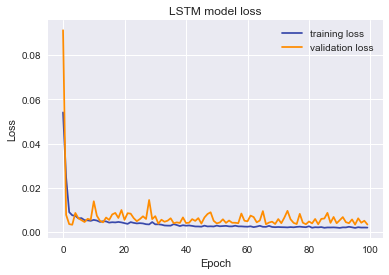

In [11]:
# Summarize history for loss
plt.plot(history_lstm.history['loss'], label='training loss', color=blue)
plt.plot(history_lstm.history['val_loss'], label='validation loss', color=orange)
plt.title('LSTM model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

#### GRU model

In [12]:
model_gru = Sequential()
# X_train.shape[1] == n_past
# X_train.shape[2] == n_features
model_gru.add(GRU(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_gru.add(Dropout(0.1))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(Dropout(0.1))
model_gru.add(GRU(16, activation='relu', return_sequences=False))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(y_train.shape[1], activation='sigmoid'))

model_gru.compile(optimizer='adam', loss=losses.mse, metrics=[metrics.mae])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 128)           51072     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 32)            15456     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [13]:
# Fit the model
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Train on 563 samples, validate on 90 samples
Epoch 1/100
563/563 [==============================] - 5s 8ms/sample - loss: 0.0539 - mean_absolute_error: 0.2061 - val_loss: 0.0794 - val_mean_absolute_error: 0.2755
Epoch 2/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0292 - mean_absolute_error: 0.1410 - val_loss: 0.0065 - val_mean_absolute_error: 0.0735
Epoch 3/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0091 - mean_absolute_error: 0.0752 - val_loss: 0.0042 - val_mean_absolute_error: 0.0563
Epoch 4/100
563/563 [==============================] - 1s 2ms/sample - loss: 0.0078 - mean_absolute_error: 0.0680 - val_loss: 0.0031 - val_mean_absolute_error: 0.0404
Epoch 5/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0074 - mean_absolute_error: 0.0673 - val_loss: 0.0026 - val_mean_absolute_error: 0.0413
Epoch 6/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0058 - mean_absolute_error: 0.0612 - val_

Epoch 98/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0018 - mean_absolute_error: 0.0325 - val_loss: 0.0018 - val_mean_absolute_error: 0.0306
Epoch 99/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 0.0022 - val_mean_absolute_error: 0.0332
Epoch 100/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0017 - mean_absolute_error: 0.0323 - val_loss: 0.0019 - val_mean_absolute_error: 0.0299


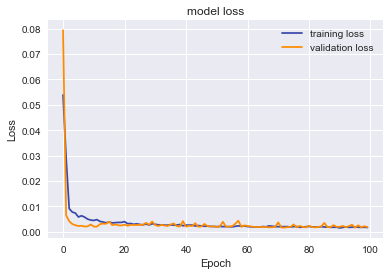

In [14]:
# Summarize history for loss
plt.plot(history_gru.history['loss'], label='training loss', color=blue)
plt.plot(history_gru.history['val_loss'], label='validation loss', color=orange)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

### Making predictions

In [15]:
train_dates = dates[:y_train.shape[0]]
test_dates = dates[-y_test.shape[0]:]

In [16]:
# In order to make predictions we need to inverse MinMaxScaler on our forecats.
# Since we used 4 variables to scale it, we will need that same shape to rescale [x, 4]
# We can just copy our values 4 times with np.repeat

def inverse_scale(data_to_inverse, n_features, scaler, column=0):
    """Inverts scaled data to its original values
    
    Parameters
    ----------
    scaler : scaler used for the first inversion.
    data_to_inverse : np.array to inverse.
    n_features : Columns to repeat.
    column : Column to return as a vector.
        Default, first column, as closing price is.
    """
    copy = np.repeat(data_to_inverse, n_features, 1)
    
    return scaler.inverse_transform(copy)[:, column]

In [17]:
# Make predictions for LSTM
train_predict_scaled_lstm = model_lstm.predict(X_train)
test_predict_scaled_lstm = model_lstm.predict(X_test)
# Inverse scaling
train_predict_lstm = inverse_scale(train_predict_scaled_lstm, n_features, scaler)
test_predict_lstm = inverse_scale(test_predict_scaled_lstm, n_features, scaler)

# Make predictions for GRU
train_predict_scaled_gru = model_gru.predict(X_train)
test_predict_scaled_gru = model_gru.predict(X_test)
# Inverse scaling
train_predict_gru = inverse_scale(train_predict_scaled_gru, n_features, scaler)
test_predict_gru = inverse_scale(test_predict_scaled_gru, n_features, scaler)


y_train = inverse_scale(y_train, n_features, scaler)
y_test = inverse_scale(y_test, n_features, scaler)

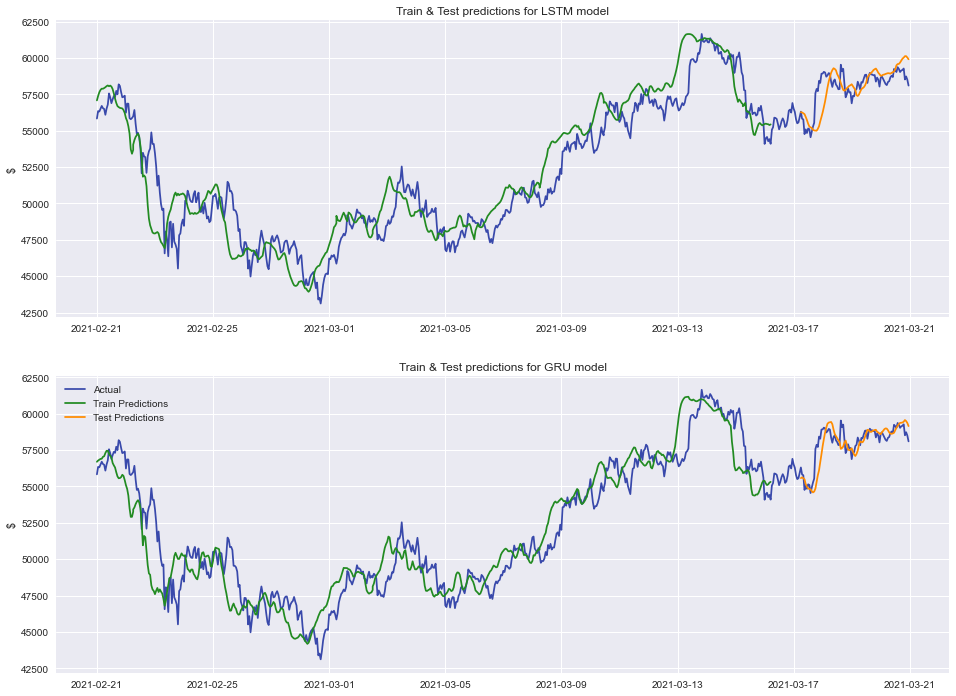

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# LSTM plot
axes[0].set_title('Train & Test predictions for LSTM model')
axes[0].plot(dates, df['close'], label='Actual', color=blue)
axes[0].plot(train_dates, train_predict_lstm, label='Train Predictions', color=green)
axes[0].plot(test_dates, test_predict_lstm, label='Test Predictions', color=orange)
axes[0].set_ylabel('$')
# GRU plot
axes[1].set_title('Train & Test predictions for GRU model')
axes[1].plot(dates, df['close'], label='Actual', color=blue)
axes[1].plot(train_dates, train_predict_gru, label='Train Predictions', color=green)
axes[1].plot(test_dates, test_predict_gru, label='Test Predictions', color=orange)
axes[1].set_ylabel('$')
axes[1].legend()

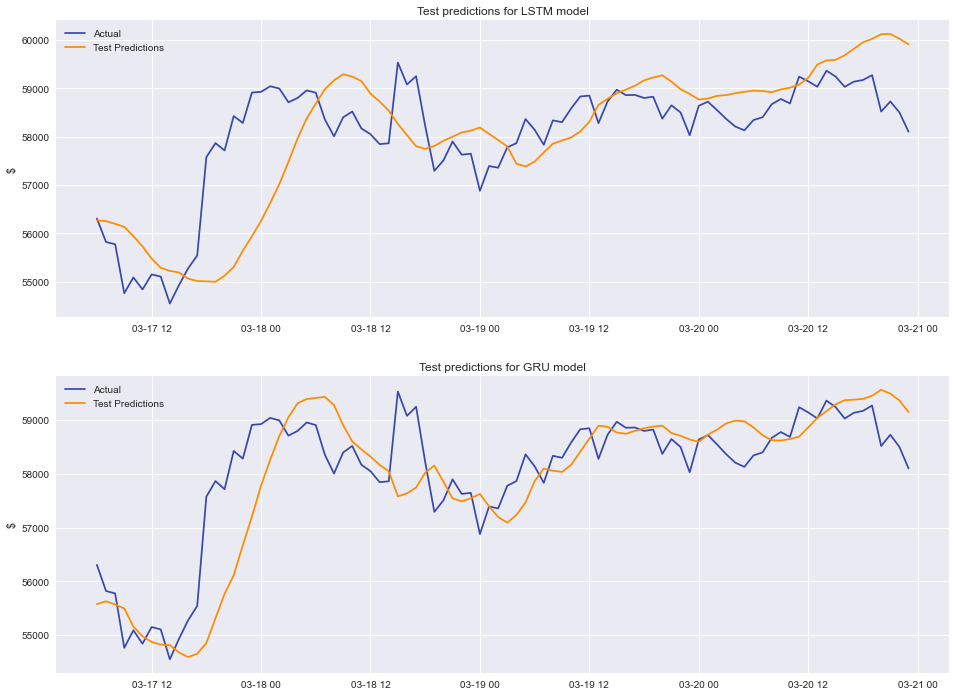

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# LSTM plot
axes[0].set_title('Test predictions for LSTM model')
axes[0].plot(test_dates, y_test, label='Actual', color=blue)
axes[0].plot(test_dates, test_predict_lstm, label='Test Predictions', color=orange)
axes[0].set_ylabel('$')
axes[0].legend()
# GRU plot
axes[1].set_title('Test predictions for GRU model')
axes[1].plot(test_dates, y_test, label='Actual', color=blue)
axes[1].plot(test_dates, test_predict_gru, label='Test Predictions', color=orange)
axes[1].set_ylabel('$')
axes[1].legend()

In [20]:
# LSTM metrics

# root mean squared error
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict_lstm))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict_lstm))
# mean absolute error
train_mae = mean_absolute_error(y_train, train_predict_lstm)
test_mae = mean_absolute_error(y_test, test_predict_lstm)

print(' --- LSTM metrics --- ')
print('Train Score: %.2f RMSE' %train_rmse)
print('Test Score: %.2f RMSE' %test_rmse)
print()
print('Train Score: %.2f MAE' %train_mae)
print('Test Score: %.2f MAE' %test_mae)

 --- LSTM metrics --- 
Train Score: 763.67 RMSE
Test Score: 1086.80 RMSE

Train Score: 600.83 MAE
Test Score: 805.90 MAE


In [21]:
# GRU metrics

# root mean squared error
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict_gru))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict_gru))
# mean absolute error
train_mae = mean_absolute_error(y_train, train_predict_gru)
test_mae = mean_absolute_error(y_test, test_predict_gru)

print(' ---- GRU metrics ---- ')
print('Train Score: %.2f RMSE' %train_rmse)
print('Test Score: %.2f RMSE' %test_rmse)
print()
print('Train Score: %.2f MAE' %train_mae)
print('Test Score: %.2f MAE' %test_mae)

 ---- GRU metrics ---- 
Train Score: 585.36 RMSE
Test Score: 797.05 RMSE

Train Score: 451.83 MAE
Test Score: 553.89 MAE


**Conclusion**

It can be clearly seen that neural networks perform better predicting bitcoin prices based on the input features than statistical inference methods such as VAR. Metrics root mean squared error and mean absolute error were calculated for each model.

In [23]:
# # For streamlit purposes
# lstm_forecast = pd.DataFrame()
# lstm_forecast['dates'] = test_dates
# lstm_forecast['actual'] = y_test
# lstm_forecast['forecast'] = test_predict_lstm
# lstm_forecast.head()

# gru_forecast = pd.DataFrame()
# gru_forecast['dates'] = test_dates
# gru_forecast['actual'] = y_test
# gru_forecast['forecast'] = test_predict_gru
# gru_forecast.head()

# lstm_forecast.to_csv('../data/forecasts/lstm.csv', index=False)
# gru_forecast.to_csv('../data/forecasts/gru.csv', index=False)